# Sentiment Analysis Project  
## Notebook 03: Sentiment Mapping & Class Imbalance Handling

This notebook focuses on converting mental health categories into sentiment labels
and analyzing class imbalance before feature engineering and modeling.


In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler

# resample the dataset
from sklearn.utils import resample
from sklearn.utils import shuffle

# import various functions from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# import the XGBoost function for classification
from xgboost import XGBClassifier

import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Noise removal
import re

# nltk = text work
import nltk

# stopwords = useless words
from nltk.corpus import stopwords

# tokenize = split words
from nltk.tokenize import word_tokenize,sent_tokenize

# stem = cut words, lemma = real words
from nltk.stem import PorterStemmer, WordNetLemmatizer

# download needed files
nltk.download('punkt')        # word split
nltk.download('punkt_tab')    # extra split
nltk.download('stopwords')    # useless words list
nltk.download('wordnet')      # dictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
path='/content/drive/MyDrive/NLP_GENAI_GL/PROJECT'

In [16]:
data=pd.read_csv(path+'/data/processed_data_cleaned.csv')

In [17]:
df=data.copy()
df.head(3)

,statement,status,text_length,clean_statement,clean_text_length
0,oh my gosh,Anxiety,10,oh gosh,7
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety,64,trouble sleeping confused mind restless heart tune,50
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety,78,wrong back dear forward doubt stay restless restless place,58


## Why Multi-Class Classification?

The dataset contains multiple mental health categories such as Anxiety,
Depression, Stress, and Suicidal.

Instead of converting these labels into binary sentiment early,
we keep all original categories to preserve information and model
the real-world problem more accurately.

Binary sentiment can always be derived later from multi-class predictions.


In [18]:
# Check available columns
df.columns

Index(['statement', 'status', 'text_length', 'clean_statement',
       'clean_text_length'],
      dtype='object')

In [19]:
# Preview target column
df[['statement', 'status']].head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,I've shifted my focus to something else but I'm still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


## Target Variable Description

The `status` column represents the mental health category associated
with each text statement.

This column will be used directly as the target variable for
multi-class text classification.


In [20]:
# Check unique mental health categories
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

## Class Distribution Analysis

Before modeling, it is important to understand how samples
are distributed across different mental health categories.

This helps identify class imbalance, which is common in real-world data.


In [22]:
# Count samples per class
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


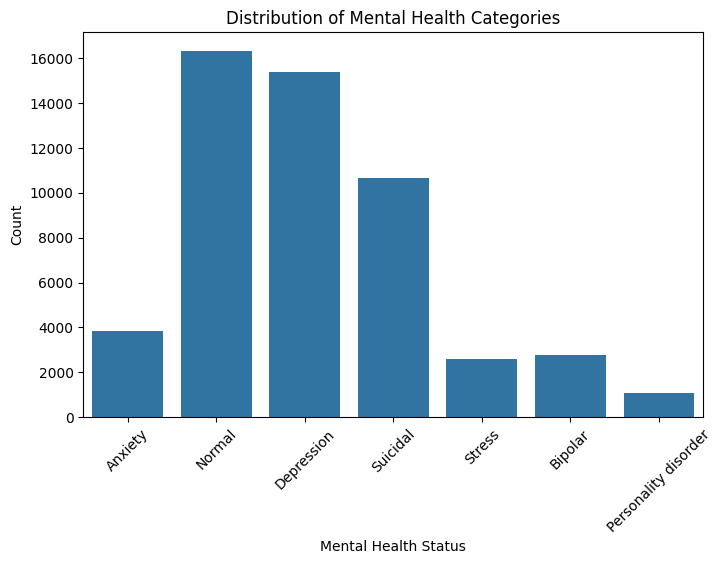

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='status')
plt.xticks(rotation=45)
plt.title("Distribution of Mental Health Categories")
plt.xlabel("Mental Health Status")
plt.ylabel("Count")
plt.show()

## Class Imbalance Observation

The dataset shows clear class imbalance:

- Categories like Normal and Depression have higher sample counts
- Categories such as Bipolar and Personality disorder have fewer samples

This imbalance reflects real-world mental health data and is not an error.

## Class Imbalance Handling Strategy

At this stage, class imbalance will not be corrected using resampling.

Reasoning:
- Text data contains rich semantic information
- Modern classifiers can handle imbalance using class weights
- Artificial balancing may distort real language patterns

Model-level techniques and evaluation metrics will be used instead.


## Optional: Balanced Dataset for Comparison

A balanced version of the dataset can be created for experimental purposes.
This will not replace the original dataset but will be used only for comparison.


In [24]:
# Get minimum class size
min_count = df['status'].value_counts().min()

# Create balanced dataset
df_balanced = (
    df.groupby('status')
      .apply(lambda x: x.sample(min_count, random_state=42))
      .reset_index(drop=True)
)

# Check balanced distribution
df_balanced['status'].value_counts()

,count
status,
Anxiety,1077
Bipolar,1077
Depression,1077
Normal,1077
Personality disorder,1077
Stress,1077
Suicidal,1077


## Original vs Balanced Dataset

Two datasets will be retained:

- Original dataset: reflects real-world distribution
- Balanced dataset: used for experimental comparison

Final model selection will be based on evaluation metrics
rather than class balance alone.


## Saving Prepared Datasets

The datasets prepared in this notebook will be used
in the next stage for feature extraction and model training.

In [26]:
# Save original dataset
df.to_csv(path+"/data/processed_multiclass_data.csv", index=False)

# Save balanced dataset
df_balanced.to_csv(path+"/data/processed_multiclass_data_balanced.csv", index=False)

## Summary

- The original mental health categories were retained as prediction targets
- Multi-class classification was chosen to avoid information loss
- Class imbalance was analyzed and acknowledged
- Both original and balanced datasets were prepared for modeling

The next notebook will focus on feature extraction using TF-IDF
and training multi-class machine learning models.
